# MNIST Prediction with Convolutional Neural Network

- MNIST dataset: is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images. More info can be found at the [MNIST homepage](http://yann.lecun.com/exdb/mnist/).
- Goal: build a simple artificial neural network to predict the digit in the images.

#### Import libraries

In [466]:
# numpy for linear algebra
import numpy as np

# matplotlib for plotting the images, loss and accuracy
import matplotlib.pyplot as plt


# tqdm for progress bar
from tqdm import tqdm

# keras for mnist dataset
from keras import datasets

#### 1. Libs 

##### 1.1. Base Layer class

The base layer class is the parent class of all layers in the network. It has the following methods:
- `forward`: forward pass of the layer
- `backpropagation`: backward pass of the layer

In [467]:
class BaseLayer:
    def __init__(self) -> None:
        self.input = None
        self.output = None

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        :param X: input data

        TODO: return the output of the layer
        """
        pass

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        """
        :param dZ: gradient of the loss with respect to the output of the layer
        :param lr: learning rate

        TODO: update parameters and return the gradient of the input
        """
        pass

##### 1.2. Weight Initialization

The weight initialization class has the following methods:

- `zeros`: initialize weights with zeros
- `ones`: initialize weights with ones
- `random`: initialize weights with random values
- `random uniform`: initialize weights with random values from a uniform distribution

In [468]:
class WeightInitializer:
    def __init__(self, shape: tuple, init_type: str = "random", seed: int = 69) -> None:
        """
        :param shape: shape of the weight matrix
        :param init_type: type of the activation function to be used (zeros, ones, random, random_uniform)
        :param seed: seed for random number generation
        """
        self.shape = shape
        self.init_type = init_type
        self.seed = seed

    def zeros(self) -> np.ndarray:
        """
        Generate a matrix of zeros
        """
        np.random.seed(self.seed)
        return np.zeros(shape=self.shape)

    def ones(self) -> np.ndarray:
        """
        Generate a matrix of ones
        """
        np.random.seed(self.seed)
        return np.ones(shape=self.shape)

    def random(self) -> np.ndarray:
        """
        Generate a matrix of random numbers
        """
        np.random.seed(self.seed)
        return np.random.randn(*self.shape)

    def random_uniform(self) -> np.ndarray:
        """
        Generate a matrix of random numbers from a uniform distribution
        """
        np.random.seed(self.seed)
        return np.random.uniform(-1, 1, size=self.shape)

    def get(self) -> np.ndarray:
        if self.init_type == "zeros":
            return self.zeros()
        elif self.init_type == "ones":
            return self.ones()
        elif self.init_type == "random":
            return self.random()
        elif self.init_type == "random_uniform":
            return self.random_uniform()
        else:
            raise ValueError("Valid types are zeros, ones, random, random_uniform")

##### 1.3. Cost Function

The cost function class has the following methods:

- `mean squared error`: mean squared error cost function: $C = \frac{1}{2n} \sum_x ||y - a||^2$
- `binary cross entropy`: binary cross entropy cost function: $C = -\frac{1}{n} \sum_x [y \ln a + (1 - y) \ln (1 - a)]$

In [469]:
class Cost:
    def __init__(self, cost_type: str = "mse") -> None:
        """
        :param cost_type: type of cost function to use (mse, cross_entropy)
        """
        self.cost_type = cost_type

    def mse(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        :param y_true: true values
        :param y_pred: predicted values
        """
        return np.mean((y_true - y_pred) ** 2)

    def d_mse(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        :param y_true: true values
        :param y_pred: predicted values
        """
        return 2 * (y_pred - y_true) / np.size(y_true)

    def cross_entropy(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        :param y_true: true values
        :param y_pred: predicted values
        """
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def d_cross_entropy(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        """
        :param y_true: true values
        :param y_pred: predicted values
        """
        return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

    def get_cost(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        if self.cost_type == "mse":
            return self.mse(y_true, y_pred)
        elif self.cost_type == "cross_entropy":
            return self.cross_entropy(y_true, y_pred)
        else:
            raise ValueError("Valid cost types are mse, cross_entropy")

    def get_d_cost(self, y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        if self.cost_type == "mse":
            return self.d_mse(y_true, y_pred)
        elif self.cost_type == "cross_entropy":
            return self.d_cross_entropy(y_true, y_pred)
        else:
            raise ValueError("Valid cost types are mse, cross_entropy")

##### 1.4. Plotting function
The plotting functions is used to plot the images and its true labels and predicted labels.

In [470]:
def plot_data(
    X: np.ndarray,
    y: np.ndarray,
    y_proba: np.ndarray = None,
    shape: tuple[int, int] = (2, 4),
) -> None:
    """
    :param X: input data (images)
    :param y: true labels
    :param y_proba: predicted labels
    :param shape: shape of the plot (nrows, ncols)
    """
    nrows, ncols = shape
    _, axes = plt.subplots(nrows, ncols, figsize=(10, 5))

    len_x = X.shape[0]
    for idx in range(nrows * ncols):
        ax = axes[idx // ncols, idx % ncols]

        img_idx = np.random.randint(0, len_x)

        ax.imshow(X[img_idx], cmap="gray")
        ax.set(xticks=[], yticks=[])

        true_label = f"True: {y[img_idx]}"
        color = "black"

        if y_proba is not None:
            pred_label = f"Pred: {y_proba[img_idx]}"
            color = "green" if y[img_idx] == y_proba[img_idx] else "red"

        img_title = true_label if y_proba is None else f"{true_label}\n{pred_label}"
        ax.set_xlabel(img_title, color=color)

    plt.tight_layout()
    plt.show()

#### 2. Layers

##### 2.1. Convolutional Layer

In [471]:
class Conv2D(BaseLayer):
    def __init__(
        self,
        inp_shape: tuple,
        kernel_size: int = 3,
        depth: int = 1,
        p: int = 0,
        s: int = 1,
        init_type: str = "random",
    ) -> None:
        """
        :param inp_shape: shape of the input data
        :param kernel_size: size of the kernel
        :param depth: depth of the output data
        :param p: padding
        :param s: stride
        :param w_init_type: type of weight initialization
        """
        inp_depth, inp_height, inp_width = inp_shape
        self.inp_shape = inp_shape
        self.kernel_size = kernel_size
        self.depth = depth
        self.p = p
        self.s = s

        self.out_shape = (
            depth,
            (inp_height - kernel_size + 2 * p) // s + 1,
            (inp_width - kernel_size + 2 * p) // s + 1,
        )
        self.kernels_shape = (depth, kernel_size, kernel_size)
        self.kernels = WeightInitializer(
            shape=self.kernels_shape, init_type=init_type
        ).get()
        self.bias = WeightInitializer(shape=self.out_shape, init_type=init_type).get()

    def get_roi(self, X: np.ndarray):
        for row in range(self.out_shape[1]):
            for col in range(self.out_shape[2]):
                yield row, col, X[
                    :, row : row + self.kernel_size, col : col + self.kernel_size
                ]

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        self.output = np.copy(self.bias)

        for row, col, roi in self.get_roi(X):
            self.output[:, row, col] = np.sum(roi * self.kernels, axis=(1, 2))

        return self.output

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        dK = np.zeros(self.kernels_shape)
        dX = np.zeros(self.inp_shape)

        for row, col, roi in self.get_roi(self.X):
            dK += dZ[:, row, col].reshape(-1, 1, 1) * roi
            dX[:, row : row + self.kernel_size, col : col + self.kernel_size] += np.sum(
                self.kernels * dZ[:, row, col].reshape(-1, 1, 1), axis=0
            )

        self.kernels -= lr * dK
        self.bias -= lr * dZ
        return dX

##### 2.2. Max Pooling Layer

In [472]:
class Pooling2D(BaseLayer):
    def __init__(self, inp_shape: tuple, pool_size: int = 2, s: int = 2) -> None:
        """
        :param inp_shape: shape of the input data
        :param pool_size: size of the pooling
        :param s: stride
        """
        inp_depth, inp_height, inp_width = inp_shape
        self.inp_shape = inp_shape
        self.pool_size = pool_size
        self.s = s

        self.out_shape = (
            inp_depth,
            (inp_height - pool_size) // s + 1,
            (inp_width - pool_size) // s + 1,
        )

    def get_roi(self, X: np.ndarray):
        for row in range(0, self.inp_shape[1] - self.pool_size + 1, self.s):
            for col in range(0, self.inp_shape[2] - self.pool_size + 1, self.s):
                yield row, col, X[
                    :, row : row + self.pool_size, col : col + self.pool_size
                ]

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        self.output = WeightInitializer(shape=self.out_shape, init_type="zeros").get()

        for row, col, roi in self.get_roi(X):
            self.output[:, row // self.s, col // self.s] = np.max(roi, axis=(1, 2))

        return self.output

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        dX = WeightInitializer(shape=self.inp_shape, init_type="zeros").get()

        for row, col, roi in self.get_roi(self.X):
            mask = np.max(roi, axis=(1, 2), keepdims=True) == roi
            dX[:, row : row + self.pool_size, col : col + self.pool_size] += (
                mask * dZ[:, row // self.s, col // self.s][:, None, None]
            )

        return dX

##### 2.3. Dense Layer class

In [473]:
class Dense(BaseLayer):
    def __init__(self, inp_size: int, out_size: int, init_type: str = "random") -> None:
        """
        :param inp_size: input size of the layer
        :param out_size: output size of the layer
        :param init_type: type of weight initialization (zeros, ones, random, random_uniform)
        """
        self.weights = WeightInitializer(
            shape=(out_size, inp_size), init_type="random"
        ).get()
        self.bias = WeightInitializer(shape=(out_size, 1), init_type="random").get()

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        return np.dot(self.weights, self.X) + self.bias

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        dW = np.dot(dZ, self.X.T)
        self.weights -= lr * dW
        self.bias -= lr * dZ
        return np.dot(self.weights.T, dZ)

##### 2.4. Activation Layer class

- `linear`: linear activation function $f(x) = x$
- `reLU`: rectified linear unit activation function $f(x) = max(0, x)$
- `sigmoid`: sigmoid activation function $f(x) = \frac{1}{1 + e^{-x}}$
- `tanh`: hyperbolic tangent activation function $f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

In [474]:
class Activation(BaseLayer):
    def __init__(self, act_type: str = "reLU") -> None:
        """
        :param act_type: type of the activation function to be used (linear, reLU, sigmoid, tanh)
        """
        self.act_type = act_type

    def linear(self, X: np.ndarray) -> np.ndarray:
        return X

    def d_linear(self, X: np.ndarray) -> np.ndarray:
        return 1

    def reLU(self, X: np.ndarray) -> np.ndarray:
        return np.maximum(0, X)

    def d_reLU(self, X: np.ndarray) -> np.ndarray:
        return np.where(X > 0, 1, 0)

    def sigmoid(self, X: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-X))

    def d_sigmoid(self, X: np.ndarray) -> np.ndarray:
        return self.sigmoid(X) * (1 - self.sigmoid(X))

    def tanh(self, X: np.ndarray) -> np.ndarray:
        return np.tanh(X)

    def d_tanh(self, X: np.ndarray) -> np.ndarray:
        return 1 - np.tanh(X) ** 2

    def get_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act_type == "linear":
            return self.linear(X)
        elif self.act_type == "reLU":
            return self.reLU(X)
        elif self.act_type == "sigmoid":
            return self.sigmoid(X)
        elif self.act_type == "tanh":
            return self.tanh(X)
        else:
            raise ValueError("Invalid activation type")

    def get_d_activation(self, X: np.ndarray) -> np.ndarray:
        if self.act_type == "linear":
            return self.d_linear(X)
        elif self.act_type == "reLU":
            return self.d_reLU(X)
        elif self.act_type == "sigmoid":
            return self.d_sigmoid(X)
        elif self.act_type == "tanh":
            return self.d_tanh(X)
        else:
            raise ValueError("Invalid activation type")

    def forward(self, X: np.ndarray) -> np.ndarray:
        self.X = X
        return self.get_activation(self.X)

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        return np.multiply(dZ, self.get_d_activation(self.X))

##### 2.5. Reshape Layer class

In [475]:
class Reshape(BaseLayer):
    def __init__(self, inp_shape: tuple, out_shape: tuple) -> None:
        """
        :param inp_shape: shape of the input data
        :param out_shape: shape of the output data
        """
        self.inp_shape = inp_shape
        self.out_shape = out_shape

    def forward(self, X: np.ndarray) -> np.ndarray:
        return np.reshape(X, self.out_shape)

    def backpropagation(self, dZ: np.ndarray, lr: float) -> np.ndarray:
        return np.reshape(dZ, self.inp_shape)

#### 3. Convolutional Neural Network (CNN) Model class

In [490]:
class CNN:
    def __init__(self, layers: list[BaseLayer]) -> None:
        if not layers:
            raise ValueError("No layers provided")
        else:
            self.layers = layers

        # Initialize the network architecture
        self.layer_name = []
        self.architecture = []

    def create_network_architecture(self):
        for layer in self.layers:
            layer_name = layer.__class__.__name__
            if layer_name in ["Conv2D", "Pooling2D", "Reshape"]:
                self.layer_name.append(layer_name)
                self.architecture.append(layer.out_shape)
            elif layer_name == "Dense":
                self.layer_name.append("Dense")
                self.architecture.append(layer.weights.shape)
            elif layer_name == "Activation":
                continue

    def compile(self, cost_type: str, lr: float, verbose: bool = True) -> None:
        """
        :param cost_type: type of cost function to use (mse, cross_entropy)
        :param lr: learning rate
        :param verbose: whether to print the cost and accuracy after each epoch
        """
        self.cost = Cost(cost_type)
        self.lr = lr
        self.verbose = verbose

    def summary(self) -> None:
        self.create_network_architecture()
        len_assigned = [45, 26, 15]
        count = {
            "Dense": 1,
            "Activation": 1,
            "Conv2D": 1,
            "Pooling2D": 1,
            "Reshape": 1,
        }
        col_names = ["Layer (type)", "Output Shape", "Param #"]
        print("Model: CNN")
        print("-" * sum(len_assigned))

        text = ""
        for i in range(3):
            text += col_names[i] + " " * (len_assigned[i] - len(col_names[i]))
        print(text)
        print("=" * sum(len_assigned))

        total_params = 0
        for i in range(len(self.layer_name)):
            layer_name = self.layer_name[i]
            name = f"{layer_name.lower()}_{count[layer_name]} ({layer_name})"

            count[layer_name] += 1
            if self.architecture[i] is None:
                print(
                    f"{name}{' ' * (len_assigned[0] - len(name))}{' ' * (len_assigned[1] - 2)}{' ' * (len_assigned[2] - 2)}"
                )
                continue

            total_params += np.prod(self.architecture[i])
            output_shape = self.architecture[i]
            output_shape = f"({', '.join(map(str, output_shape))})"
            params = np.prod(self.architecture[i])

            print(
                f"{name}{' ' * (len_assigned[0] - len(name))}{output_shape}{' ' * (len_assigned[1] - len(output_shape))}{params}"
            )

        print("=" * sum(len_assigned))

        print(f"Total params: {total_params}")
        print(f"Cost function: {self.cost.cost_type}")
        print(f"Learning rate: {self.lr}")
        print(f"Verbose: {self.verbose}")
        print("-" * sum(len_assigned))

    def fit(self, X: np.ndarray, y: np.ndarray, epochs: int = 1000) -> None:
        """
        :param X: input data
        :param y: true labels
        :param epochs: number of epochs to train the model
        """

        # Initialize the history dictionary
        self.history = {"loss": [], "accuracy": []}

        for epoch in range(epochs):
            # Initialize the error and correct predictions
            error = 0
            correct = 0

            for i in tqdm(
                range(len(X)),
                colour="GREEN",
                ascii="░▒█",
                desc=f"Epoch {epoch + 1}/{epochs}",
            ):
                output = X[i]
                for layer in self.layers:
                    output = layer.forward(output)

                error += self.cost.get_cost(y[i], output)
                correct += int(np.argmax(output) == np.argmax(y[i]))

                dZ = self.cost.get_d_cost(y[i], output)
                for layer in reversed(self.layers):
                    dZ = layer.backpropagation(dZ, self.lr)

            self.history["loss"].append(error / len(X))
            self.history["accuracy"].append(correct / len(X))

            if self.verbose:
                print(
                    f"Loss: {self.history['loss'][-1]:.4f}, Accuracy: {self.history['accuracy'][-1]:.4f}"
                )

    def plot_history(self) -> None:
        _, ax = plt.subplots(1, 2, figsize=(15, 5))

        ax[0].plot(self.history["loss"])
        ax[0].set_title("Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")

        ax[1].plot(self.history["accuracy"])
        ax[1].set_title("Accuracy")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")

        plt.tight_layout()
        plt.show()

    def predict(self, X: np.ndarray) -> np.ndarray:
        predictions = []
        for i in range(len(X)):
            output = X[i]
            for layer in self.layers:
                output = layer.forward(output)
            predictions.append(output)

        return np.array(predictions)

#### 4. Training the model with MNIST dataset

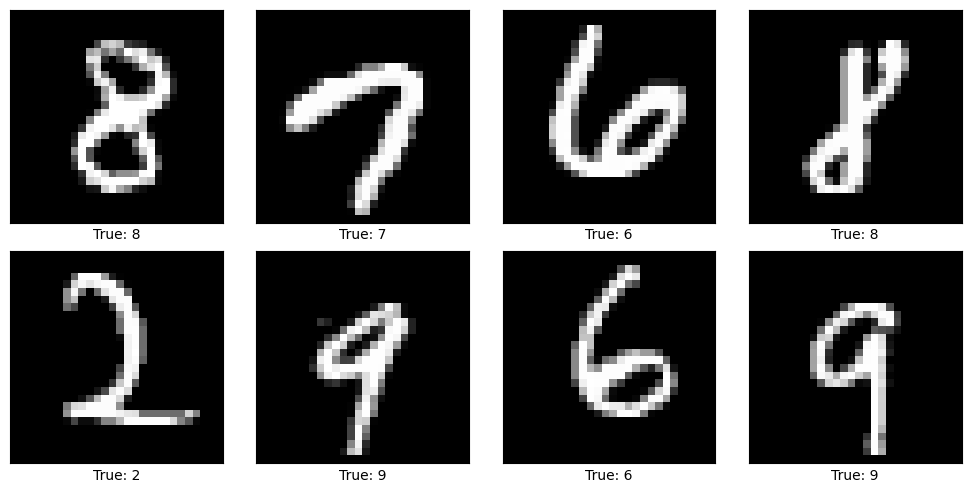

In [477]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
plot_data(X_train, y_train)

##### 4.1. Preprocessing the data

In [478]:
# Normalize the data
X_train = X_train.reshape(len(X_train), 1, 28, 28)
X_test = X_test.reshape(len(X_test), 1, 28, 28)

In [479]:
# Convert to [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [480]:
# One-hot encode the labels
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

# Reshape the labels
y_train = y_train.reshape(len(y_train), 10, 1)
y_test = y_test.reshape(len(y_test), 10, 1)

##### 4.2. Training the model

In [491]:
model = CNN(
    [
        Conv2D(
            (1, 28, 28), kernel_size=3, depth=5, p=2, s=2, init_type="random"
        ),  # output shape =(input_size - kernel_size + 2 * p) / s + 1 = (28 - 3 + 2 * 2) / 2 + 1 = 15
        Activation(act_type="sigmoid"),
        Pooling2D(
            (5, 15, 15), pool_size=2, s=2
        ),  # output shape = (input_size - pool_size) / s + 1 = (15 - 2) / 2 + 1 = 7
        Reshape((5, 7, 7), (5 * 7 * 7, 1)),
        Dense(5 * 7 * 7, 100),
        Activation(act_type="sigmoid"),
        Dense(100, 10),
        Activation(act_type="sigmoid"),
    ]
)

model.compile(cost_type="cross_entropy", lr=0.01)

In [492]:
model.summary()

Model: CNN
--------------------------------------------------------------------------------------
Layer (type)                                 Output Shape              Param #        
conv2d_1 (Conv2D)                            (5, 15, 15)               1125
pooling2d_1 (Pooling2D)                      (5, 7, 7)                 245
reshape_1 (Reshape)                          (245, 1)                  245
dense_1 (Dense)                              (100, 245)                24500
dense_2 (Dense)                              (10, 100)                 1000
Total params: 27115
Cost function: cross_entropy
Learning rate: 0.01
Verbose: True
--------------------------------------------------------------------------------------


In [483]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10: 100%|██████████| 60000/60000 [04:12<00:00, 237.71it/s]


Loss: 0.2417, Accuracy: 0.4959


Epoch 2/10: 100%|██████████| 60000/60000 [04:12<00:00, 237.34it/s]


Loss: 0.1867, Accuracy: 0.6388


Epoch 3/10: 100%|██████████| 60000/60000 [04:17<00:00, 233.41it/s]


Loss: 0.1662, Accuracy: 0.6878


Epoch 4/10: 100%|██████████| 60000/60000 [04:10<00:00, 239.15it/s]


Loss: 0.1527, Accuracy: 0.7178


Epoch 5/10: 100%|██████████| 60000/60000 [04:15<00:00, 235.15it/s]


Loss: 0.1429, Accuracy: 0.7384


Epoch 6/10: 100%|██████████| 60000/60000 [04:16<00:00, 233.47it/s]


Loss: 0.1352, Accuracy: 0.7544


Epoch 7/10: 100%|██████████| 60000/60000 [04:14<00:00, 235.65it/s]


Loss: 0.1291, Accuracy: 0.7659


Epoch 8/10: 100%|██████████| 60000/60000 [04:20<00:00, 230.03it/s]


Loss: 0.1242, Accuracy: 0.7756


Epoch 9/10: 100%|██████████| 60000/60000 [04:15<00:00, 234.69it/s]


Loss: 0.1201, Accuracy: 0.7839


Epoch 10/10: 100%|██████████| 60000/60000 [04:13<00:00, 236.48it/s]

Loss: 0.1168, Accuracy: 0.7911


##### 4.3. Model results

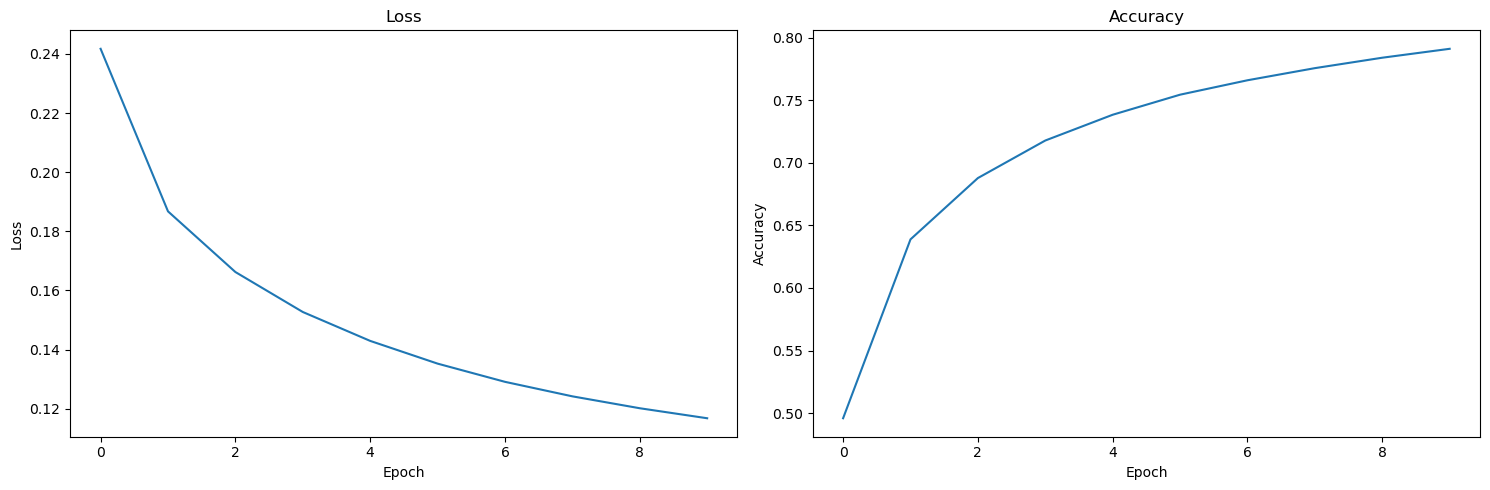

In [484]:
model.plot_history()

In [485]:
y_pred = model.predict(X_test)

print(f"Accuracy: {np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))}")

Accuracy: 0.8018


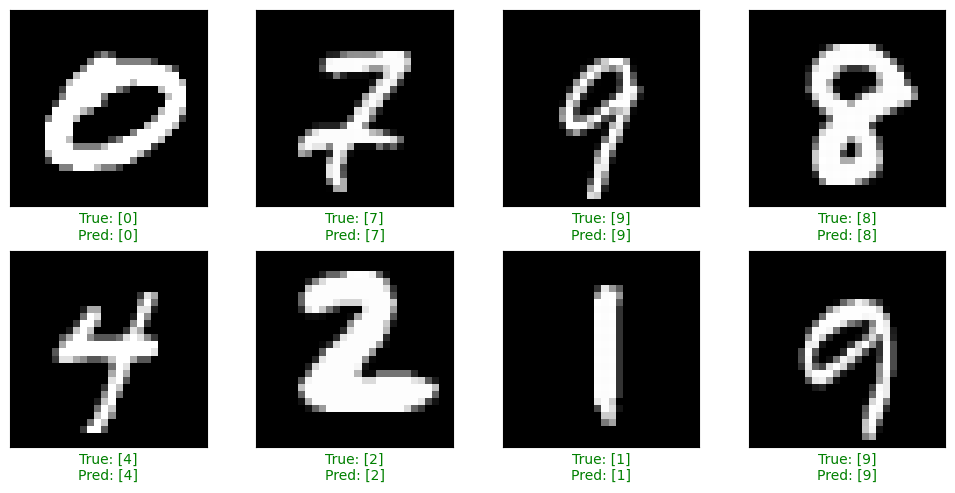

In [489]:
plot_data(
    X_test.reshape(len(X_test), 28, 28),
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
)